In [3]:
import pandas as pd
import numpy as np

def process_file(file_path, currency, convert_to_euro=False):
    df = pd.read_csv(file_path)
    
    # Convert date columns 
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Columns to be kept
    columns_to_keep = ['Close']

    # Converts numbers to floating point and removes commas
    for col in columns_to_keep:
        df[col] = df[col].replace(',', '', regex=True).astype(float)

        # Convert to Euro if required
        if convert_to_euro:
            df[col] = df[col] * 0.92

    # Handle missing values by forward filling
    df = df[columns_to_keep].fillna(method='ffill')
    
    # Add the currency as a suffix to the retained columns
    df.columns = [f"{col}_{currency}" for col in columns_to_keep]

    return df

file_paths = {
    'ETH-EUR.csv': ('ETH', False),
    'BTC-EUR.csv': ('BTC', False),
    'DOGE-EUR.csv': ('DOGE', False),
    'USDT-EUR.csv': ('USDT', False),
    'XRP-EUR.csv': ('XRP', False),
    'S&P.csv': ('SP', True),  # Convert to Euro
    'Gold.csv': ('Gold', True),  # Convert to Euro
    'Apple.csv': ('Apple', True),  # Convert to Euro
    'Nasdaq.csv': ('Nasdaq', True),  # Convert to Euro
    'Silver.csv': ('Silver', True),  # Convert to Euro
    'Oil.csv': ('Oil', True),  # Convert to Euro
    'ADA-EUR.csv': ('ADA', False)
}


# Place the adjusted data in the dictionary
dataframes = {}
for file, (code, convert_to_euro) in file_paths.items():
    df_processed = process_file(file, code, convert_to_euro)
    dataframes[code] = df_processed

# Merge all data frames
combined_df = pd.concat(dataframes.values(), axis=1)

# Define a function that cleans the data
def clean_data(df):
    # Check for NaN and infinity values
    if df.isna().any().any() or np.isinf(df).any().any():
        # Handle NaN values 
        df = df.ffill().bfill()
        
        # Handle infinity values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

df_clean = clean_data(combined_df)
print(df_clean.head())

            Close_ETH  Close_BTC  Close_DOGE  Close_USDT  Close_XRP  \
Date                                                                  
2021-12-03    3740.07    47459.0    0.177822      0.8866     0.8231   
2021-12-04    3599.83    43084.0    0.156139      0.8870     0.7392   
2021-12-05    3672.30    43547.0    0.150662      0.8854     0.7081   
2021-12-06    3832.43    44321.0    0.157217      0.8872     0.7267   
2021-12-07    3809.00    44818.0    0.158516      0.8882     0.7250   

             Close_SP  Close_Gold  Close_Apple  Close_Nasdaq  Close_Silver  \
Date                                                                         
2021-12-03  4175.3556    1641.188     148.8928      1641.188      20.68252   
2021-12-04  4175.3556    1641.188     148.8928      1641.188      20.68252   
2021-12-05  4175.3556    1641.188     148.8928      1641.188      20.68252   
2021-12-06  4224.3364    1637.140     152.0944      1637.140      20.48196   
2021-12-07  4311.8100    1641.924 

/var/folders/2m/mym43cfn0zsfm6lsl_yf2wcc0000gn/T/ipykernel_29241/1948665422.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df[columns_to_keep].fillna(method='ffill')
/var/folders/2m/mym43cfn0zsfm6lsl_yf2wcc0000gn/T/ipykernel_29241/1948665422.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df[columns_to_keep].fillna(method='ffill')
/var/folders/2m/mym43cfn0zsfm6lsl_yf2wcc0000gn/T/ipykernel_29241/1948665422.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df[columns_to_keep].fillna(method='ffill')
/var/folders/2m/mym43cfn0zsfm6lsl_yf2wcc0000gn/T/ipykernel_29241/1948665422.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill(

In [40]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test on the cleaned extended data

columns = df_clean.columns
df_clean_stationary = pd.DataFrame(index=df_clean.index)

for column in columns:
    
    # Original series ADF test
    adf_result_original = adfuller(df_clean[column].dropna())
    print(f"ADF Test Results for Original {column}:")
    print('ADF Statistic: %f' % adf_result_original[0])
    print('p-value: %f' % adf_result_original[1])

    if adf_result_original[1] < 0.05:
        print(f"The original time series of {column} is stationary.\n")
        df_clean_stationary[column] = df_clean[column]
    else:
        print(f"The original time series of {column} is not stationary.\n")
        diff_series = df_clean[column].diff().dropna()

        # Differenced series ADF test
        adf_result_diff = adfuller(diff_series.dropna())
        print(f"ADF Test Results for Differenced {column}:")
        print('ADF Statistic: %f' % adf_result_diff[0])
        print('p-value: %f' % adf_result_diff[1])

        if adf_result_diff[1] < 0.05:
            print(f"The differenced time series of {column} is stationary.\n")
            df_clean_stationary[column] = diff_series.fillna(method='bfill')
            
        else:
            print(f"The differenced time series of {column} is still not stationary.\n")
    
    print("\n" + "-"*50 + "\n")

df_clean_stationary.dropna(inplace=True)

# Display the head of the cleaned stationary extended dataframe
print(df_clean_stationary.head())


ADF Test Results for Original Close_ETH:
ADF Statistic: -3.413452
p-value: 0.010509
The original time series of Close_ETH is stationary.


--------------------------------------------------

ADF Test Results for Original Close_BTC:
ADF Statistic: -2.237581
p-value: 0.192890
The original time series of Close_BTC is not stationary.

ADF Test Results for Differenced Close_BTC:
ADF Statistic: -27.674421
p-value: 0.000000
The differenced time series of Close_BTC is stationary.


--------------------------------------------------

ADF Test Results for Original Close_DOGE:
ADF Statistic: -2.662265
p-value: 0.080799
The original time series of Close_DOGE is not stationary.

ADF Test Results for Differenced Close_DOGE:
ADF Statistic: -8.448427
p-value: 0.000000
The differenced time series of Close_DOGE is stationary.


--------------------------------------------------

ADF Test Results for Original Close_USDT:
ADF Statistic: -1.838379
p-value: 0.361581
The original time series of Close_USDT is

In [44]:
print(df_clean['Close_ETH'].head())

Date
2021-12-03    3740.07
2021-12-04    3599.83
2021-12-05    3672.30
2021-12-06    3832.43
2021-12-07    3809.00
Freq: D, Name: Close_ETH, dtype: float64


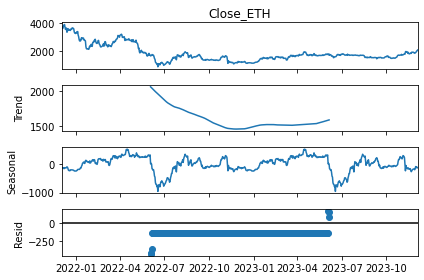

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df_clean['Close_ETH'], model='additive', period=365)
decomposition.plot()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5878.460, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5879.986, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5879.944, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5877.843, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5879.608, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.406 seconds


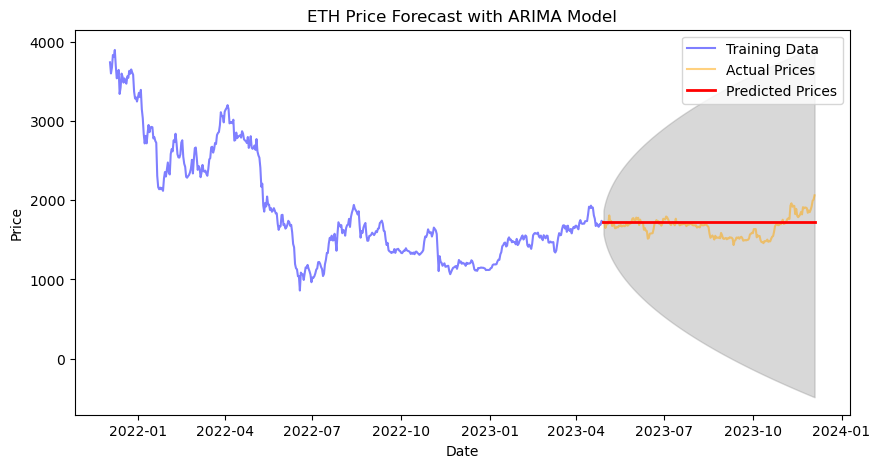

ARIMA Model RMSE: 134.25715276018897


In [4]:
# Hypothesis 3 ARIMA:

"""
The Autoregressive Integrated Moving Average (ARIMA) model is a time series forecasting

Assumptions:

Stationarity: ARIMA assumes that the time series data is stationary, which means that the statistical properties 
of the data, such as mean, variance, and autocorrelation, do not change over time. 
Stationarity is essential because ARIMA models are designed to work with stationary data. 

Autocorrelation: ARIMA assumes that there is some correlation between the values of the time series at 
different time lags. This is captured by the autoregressive (AR) component of the model. The AR component 
represents the linear relationship between the current value of the series and its past values.

Moving Average: ARIMA assumes that there is a relationship between the current value of the time series and 
the past white noise errors (residuals) in the series. This is captured by the moving average (MA) component of 
the model.

Linearity: ARIMA is a linear model, which means it assumes that the relationship between the current value and 
past values (for AR component) or past residuals (for MA component) is a linear one. Nonlinear relationships may 
not be well-captured by ARIMA.

Independence of Errors: ARIMA assumes that the errors (residuals) of the model are independent and identically 
distributed (i.i.d.). This assumption implies that there is no remaining systematic pattern or correlation in 
the residuals after applying the ARIMA model.

Adequate Data: ARIMA models require a sufficient amount of historical data to estimate model parameters
accurately. The exact amount of data needed may vary depending on the complexity of the model and the 
characteristics of the time series.

"""

from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Select only ETH closing prices for endogenous variable
endog = df_clean['Close_ETH']

# Split the data into training and validation sets
split_point = int(len(endog) * 0.7)
train_endog = endog[:split_point]
valid_endog = endog[split_point:]

# Find the best ARIMA model
auto_model = auto_arima(train_endog, seasonal=True, start_p=0, start_q=0,
                        max_p=15, max_q=15, d=None, trace=True, error_action='ignore', 
                        suppress_warnings=True, stepwise=True, information_criterion='aic')

# Fit the ARIMA model to the training data using statsmodels
model_arima = ARIMA(train_endog, order=auto_model.order)
model_arima_fit = model_arima.fit()

# Make predictions and get confidence intervals
forecast = model_arima_fit.get_forecast(steps=len(valid_endog))
predictions_arima = forecast.predicted_mean
conf_int = forecast.conf_int()

# Calculate error metrics
mse_arima = mean_squared_error(valid_endog, predictions_arima)
rmse_arima = np.sqrt(mse_arima)

# Plot the results with confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(train_endog.index, train_endog, label='Training Data', color='blue', alpha=0.5)
plt.plot(valid_endog.index, valid_endog, label='Actual Prices', color='orange', alpha=0.5)
plt.plot(valid_endog.index, predictions_arima, label='Predicted Prices', color='red', linewidth=2, linestyle='-')

# Add the confidence intervals
plt.fill_between(valid_endog.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)

plt.title('ETH Price Forecast with ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print("ARIMA Model RMSE:", rmse_arima)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8208.664, Time=1.72 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8212.157, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8214.341, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8214.560, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8211.032, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8207.061, Time=1.27 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=4.14 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8206.861, Time=2.07 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=4.94 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8204.594, Time=5.44 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=8202.672, Time=4.91 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=8204.100, Time=4.59 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=8207.335, Time=4.65 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept

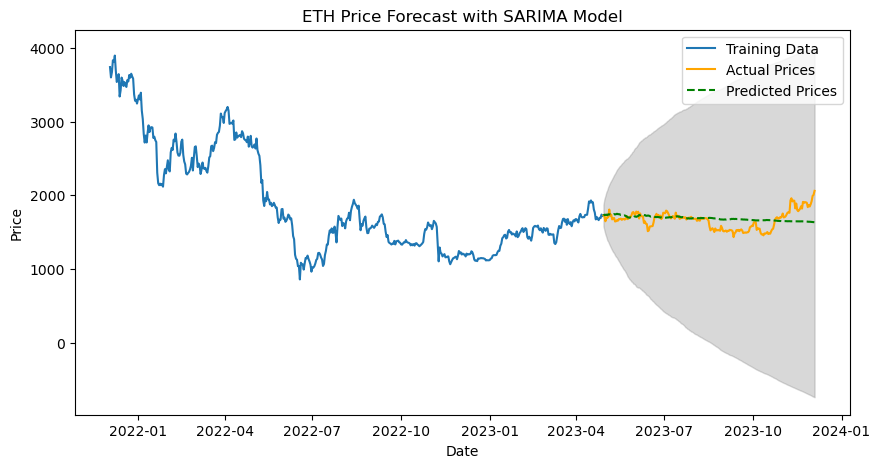

SARIMA Model MAE: 99.59323869047257
SARIMA Model MSE: 17029.168619139873
SARIMA Model RMSE: 130.4958567125404


In [10]:
# SARIMA Model
import numpy as np
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Select only ETH closing prices
endog = df_clean['Close_ETH']

# Auto SARIMA model for ETH
model_sarima = auto_arima(endog, seasonal=True, m=12, trace=True,
                          error_action='ignore', suppress_warnings=True,
                          stepwise=True)

# Split the data into training and validation sets
split_point = int(len(endog) * 0.7)
train_endog = endog[:split_point]
valid_endog = endog[split_point:]

# Fit the model
model_sarima.fit(train_endog)

# Make predictions
predictions_sarima, conf_int = model_sarima.predict(n_periods=len(valid_endog), return_conf_int=True)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(train_endog.index, train_endog, label='Training Data')
plt.plot(valid_endog.index, valid_endog, label='Actual Prices', color='orange')
plt.plot(valid_endog.index, predictions_sarima, label='Predicted Prices', color='green', linestyle='--')

# Add the confidence intervals
plt.fill_between(valid_endog.index, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.3)

plt.title('ETH Price Forecast with SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate error metrics: MAE, MSE, and RMSE
mse_sarima = mean_squared_error(valid_endog, predictions_sarima)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima = mean_absolute_error(valid_endog, predictions_sarima)

# Print the error metrics
print("SARIMA Model MAE:", mae_sarima)
print("SARIMA Model MSE:", mse_sarima)
print("SARIMA Model RMSE:", rmse_sarima)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=5877.699, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5878.460, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5880.634, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5880.785, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5877.843, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=5875.752, Time=1.14 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=5873.765, Time=0.50 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=5881.193, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=5881.075, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=5874.034, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=5874.518, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5879.608, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=5879.099, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[12]

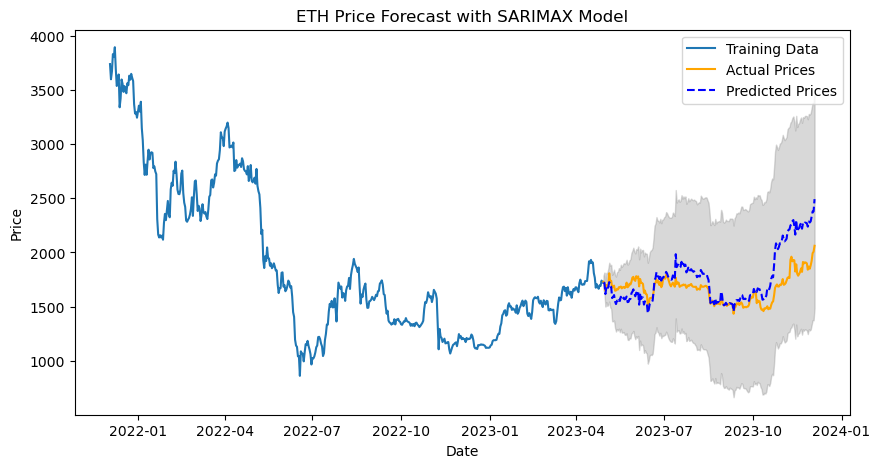

SARIMAX Model MAE: 143.98149374804882
SARIMAX Model MSE: 37938.2926246158
SARIMAX Model RMSE: 194.77754651041224


In [11]:
# SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX model with additional variables
exog = df_clean[['Close_BTC', 'Close_DOGE', 'Close_USDT', 'Close_XRP']]
endog = df_clean['Close_ETH']

# Split the data into training and validation sets
split_point = int(len(endog) * 0.7)
train_endog = endog[:split_point]
valid_endog = endog[split_point:]
train_exog = exog.iloc[:split_point]
valid_exog = exog.iloc[split_point:]

# Auto ARIMA to determine the best order and seasonal_order
auto_model = auto_arima(train_endog, exogenous=train_exog, seasonal=True, m=12, trace=True,
                        error_action='ignore', suppress_warnings=True, stepwise=True)

# Fit the SARIMAX model to the training data using the order and seasonal_order from auto_arima
model_sarimax = SARIMAX(train_endog, exog=train_exog, order=auto_model.order,
                        seasonal_order=auto_model.seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit(disp=False)

# Make predictions
predictions_sarimax = model_sarimax_fit.get_prediction(start=valid_endog.index[0], end=valid_endog.index[-1], 
                                                       exog=valid_exog)
predicted_mean_sarimax = predictions_sarimax.predicted_mean
conf_int_sarimax = predictions_sarimax.conf_int()

# Plot the results with confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(train_endog.index, train_endog, label='Training Data')
plt.plot(valid_endog.index, valid_endog, label='Actual Prices', color='orange')
plt.plot(valid_endog.index, predicted_mean_sarimax, label='Predicted Prices', color='blue', linestyle='--')

# Add the confidence intervals
plt.fill_between(valid_endog.index, conf_int_sarimax.iloc[:, 0], conf_int_sarimax.iloc[:, 1], color='gray', alpha=0.3)

plt.title('ETH Price Forecast with SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate error metrics
mse_sarimax = mean_squared_error(valid_endog, predicted_mean_sarimax)
rmse_sarimax = np.sqrt(mse_sarimax)
mae_sarimax = mean_absolute_error(valid_endog, predicted_mean_sarimax)

# Print the error metrics
print("SARIMAX Model MAE:", mae_sarimax)
print("SARIMAX Model MSE:", mse_sarimax)
print("SARIMAX Model RMSE:", rmse_sarimax)